# Loading

In [1]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
# import pandas_datareader as web
import datetime as dt

# ML/DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed,GRU,Embedding
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
import json
seed(1)

In [2]:
filepath='model3/'

In [3]:
train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)
data_oil = pd.read_csv('oil.csv')
samp_subm = pd.read_csv('sample_submission.csv')
data_holi = pd.read_csv('holidays_events.csv')
data_store =  pd.read_csv('stores.csv')
data_trans = pd.read_csv('transactions.csv')


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
## holiday 重複的部分做處理
#  type：{'holiday':3,'transfer':4,'addition:'0','bridge':1,'work day':5,'event':2} nan=6
#  local:{'local':0,'region':2,'nation':1} nan=3
data_holi = data_holi[['date','type','locale']]
ordinal_encoder = OrdinalEncoder()
c = ['type','locale']
data_holi[c] = ordinal_encoder.fit_transform(data_holi[c])
data_holi[c]=data_holi[c].astype(int)
data_holi = data_holi.groupby(['date'],as_index=False).agg({'type':'mean','locale':'first'})

In [5]:
all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data['date'] =  pd.to_datetime(all_data['date'])
data_holi['date'] = pd.to_datetime(data_holi['date'])
data_oil['date'] = pd.to_datetime(data_oil['date'])

In [6]:
df_train1 = all_data.merge(data_holi, on = 'date', how='left')
df_train1 = df_train1.merge(data_oil, on = 'date', how='left')
df_train1 = df_train1.merge(data_store, on = 'store_nbr', how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})
df_train1['day_of_week'] = df_train1['date'].dt.day_name()


In [7]:

# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df['week'] = df['date'].dt.isocalendar().week
# df['quarter'] = df['date'].dt.quarter


train_columns = ['date','store_nbr','family','sales','onpromotion','holiday_type','locale','dcoilwtico','store_type','cluster','day_of_week']
df = df_train1[train_columns]

In [8]:
num_test,num_train = len(test_data),len(train_data)

In [9]:
df_copy = df.copy()

# EDA
df = train + test

### 圖示化


In [ ]:

# buf = df[['date','store_nbr','sales','family']].groupby(['store_nbr','family','date'],as_index = False).agg({"sales":"mean"})
# store = []
# for i in range(1,55):
#     f = list(buf[buf['store_nbr']==i].drop(columns = ['store_nbr']).groupby(['family']))
#     store1 = f[0][1].drop(columns=['family'])
#     for i in range(1,33):
#         store1 = store1.merge(f[i][1].drop(columns=['family']), on = 'date', how='left')
#         store1 = store1.rename(columns = {"sales_x": "sales" ,"sales_y" : f[i][0]})
#     store1 = store1.rename(columns = {"sales": f[0][0]})  
#     store.append(store1)


### Transform

In [210]:
df =df_copy.copy()

In [ ]:
# df.info()

In [ ]:
# df.isnull().sum()

In [211]:
df['holiday_type'].fillna(6,inplace=True)
df['locale'].fillna(3,inplace=True)
df['dcoilwtico'].fillna(df['dcoilwtico'].mean(),inplace=True)
# df.isnull().sum()

In [212]:
object_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
number_cols = [cname for cname in df.columns if df[cname].dtype!="object" and cname!='date' and cname!='sales']
# buf[col] = ordinal_encoder.fit_transform(buf[col])
print(object_cols,number_cols)

['family', 'store_type', 'day_of_week'] ['store_nbr', 'onpromotion', 'holiday_type', 'locale', 'dcoilwtico', 'cluster']


In [213]:
ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

### Seperate By family

In [214]:
# train_x_all = df[:num_train].copy()

train_x_all = df.copy()
train_x_all = list(train_x_all.groupby(["family"]))

In [237]:
condition ={
    'store_nbr':'mean',#!
    'family':'mean',
    'onpromotion':'mean',#!
    'holiday_type':'mean', #!
    'locale':'mean',#!
    'dcoilwtico':'mean',#!
    'store_type':'mean',#!
    'cluster':'mean',#!
    'day_of_week':'mean'#!
    }
train_condition = condition.copy()
train_condition['sales'] ='max'

In [239]:
history_input = 30

train_f_map=list()
for i in range(len(train_x_all)):
    scaler = MinMaxScaler(feature_range=(0,1))
    family_num,train_x = train_x_all[i][0],train_x_all[i][1]
    train_x = train_x.groupby(['date'],as_index=False).agg(train_condition)#ok
    # if i==0:print(train_x)
    for col in number_cols+object_cols:
        train_x[col] = scaler.fit_transform(train_x[col].values.reshape(-1,1))
    train_x = train_x[:589]
    train_y = train_x[['date','sales']]
    train_x.drop(columns=['date','sales','family'],inplace=True)#,'store_nbr','family','onpromotion','locale','store_type','cluster'
    train_y.drop(columns=['date'],inplace=True)

    
    train_input = []
    train_output = []
    for i in range(len(train_x)-history_input+1):
        train_input.append(train_x[i:i+history_input].values)
        train_output.append(train_y.iloc[i+history_input-1])
    train_input=np.array(train_input)
    train_output=np.array(train_output)

    train_f_map.append([train_input,train_output])#,scaler])
    # break

C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=err

In [240]:
print(train_f_map[0][0].shape)
print(train_f_map[0][1].shape)

(560, 30, 8)
(560, 1)


In [151]:
# def Make_Model_GRU():    

In [244]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    
    # First LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, activation='relu', kernel_initializer='he_uniform', return_sequences = True, input_shape = train_input[0].shape )) 
    model.add(Dropout(0.2))
    
    # Second LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50,  activation='relu', kernel_initializer='he_uniform', return_sequences = True))                                    
    model.add(Dropout(0.2))
    
    # Final LSTM layer with Dropout regularisation; Set return_sequences to False since now we will be predicting with the output layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [245]:
for i in range(len(train_f_map)):
    train_input = train_f_map[i][0]
    train_output = train_f_map[i][1]

    model = Multi_Step_LSTM_model()
    model.compile(optimizer='adam', loss='mean_squared_error')#, metrics = ['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss',patience=2,verbose=1)
    history = model.fit(train_input,train_output, validation_split=0.3,batch_size=4, epochs=100,callbacks=early_stop)
    train_f_map[i].append(model)
    train_f_map[i].append(history)
    # break


Epoch 1/100
98/98 [==============================] - 6s 33ms/step - loss: 514.8374 - val_loss: 297.9545
Epoch 2/100
98/98 [==============================] - 2s 20ms/step - loss: 282.7915 - val_loss: 198.0301
Epoch 3/100
98/98 [==============================] - 2s 21ms/step - loss: 197.0906 - val_loss: 142.0529
Epoch 4/100
98/98 [==============================] - 2s 20ms/step - loss: 149.7951 - val_loss: 110.7308
Epoch 5/100
98/98 [==============================] - 2s 20ms/step - loss: 115.5358 - val_loss: 95.5385
Epoch 6/100
98/98 [==============================] - 2s 19ms/step - loss: 127.3476 - val_loss: 88.0389
Epoch 7/100
98/98 [==============================] - 2s 18ms/step - loss: 108.0043 - val_loss: 84.6324
Epoch 8/100
98/98 [==============================] - 2s 18ms/step - loss: 104.6045 - val_loss: 83.6515
Epoch 9/100
98/98 [==============================] - 2s 17ms/step - loss: 104.1408 - val_loss: 82.9017
Epoch 10/100
98/98 [==============================] - 2s 17ms/step - 

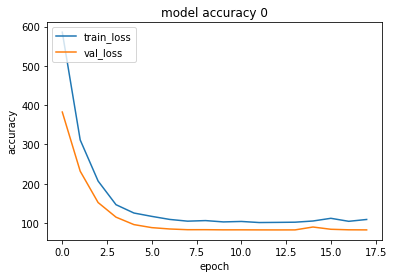

model_f0Saved model to disk


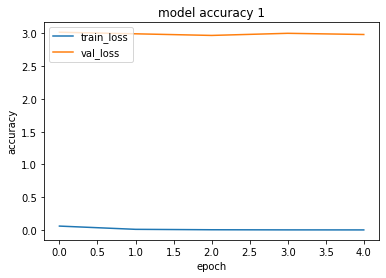

model_f1Saved model to disk


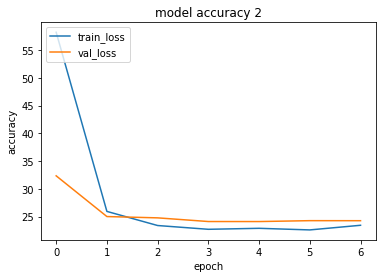

model_f2Saved model to disk


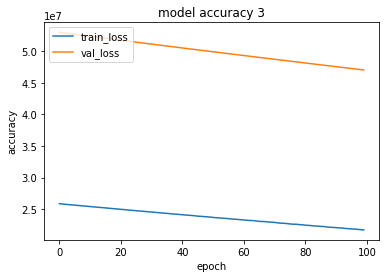

model_f3Saved model to disk


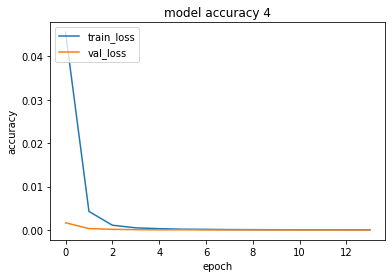

model_f4Saved model to disk


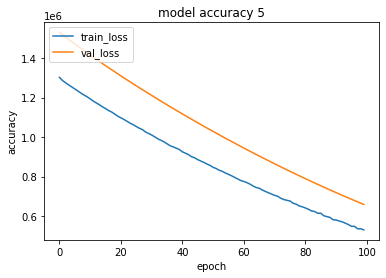

model_f5Saved model to disk


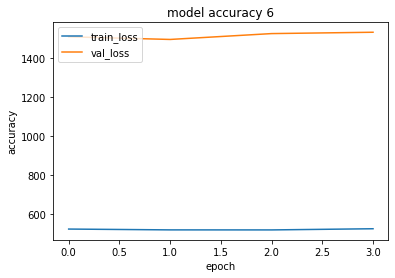

model_f6Saved model to disk


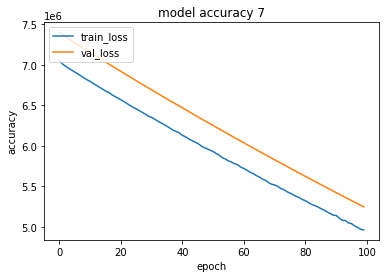

model_f7Saved model to disk


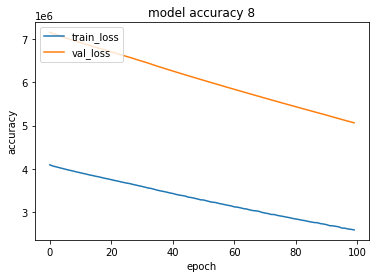

model_f8Saved model to disk


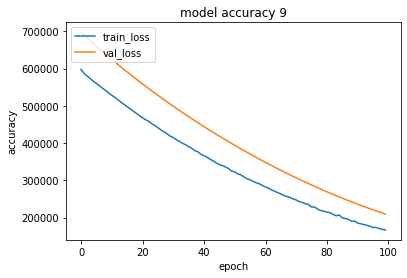

model_f9Saved model to disk


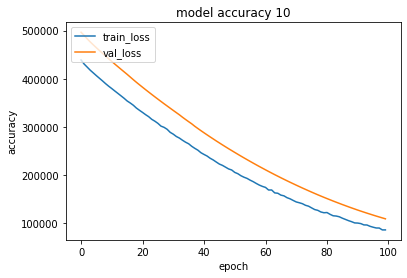

model_f10Saved model to disk


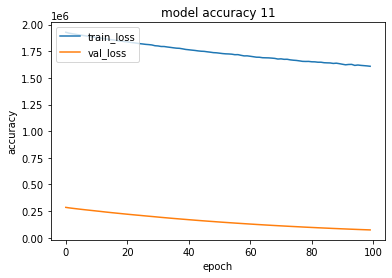

model_f11Saved model to disk


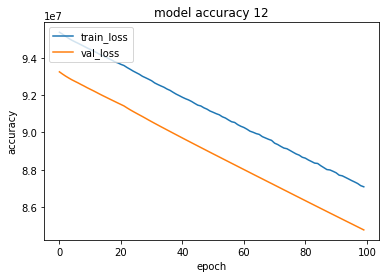

model_f12Saved model to disk


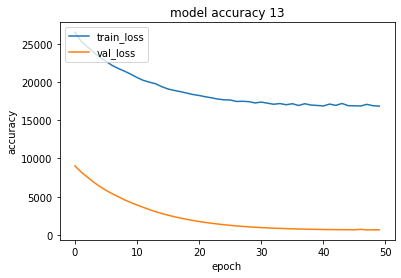

model_f13Saved model to disk


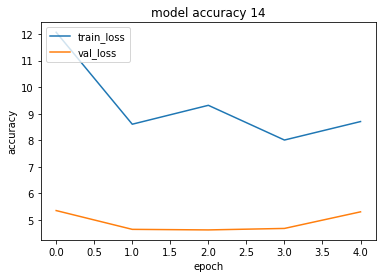

model_f14Saved model to disk


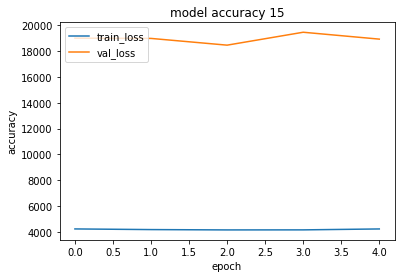

model_f15Saved model to disk


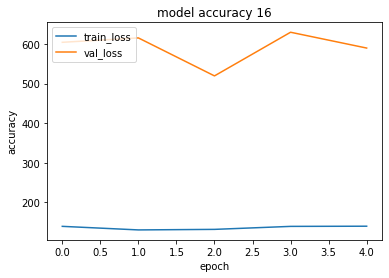

model_f16Saved model to disk


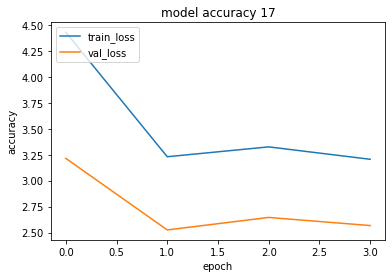

model_f17Saved model to disk


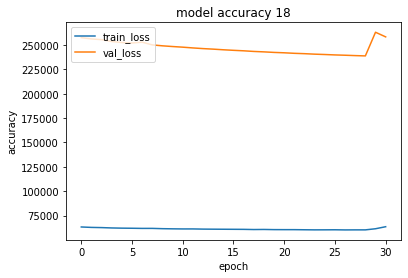

model_f18Saved model to disk


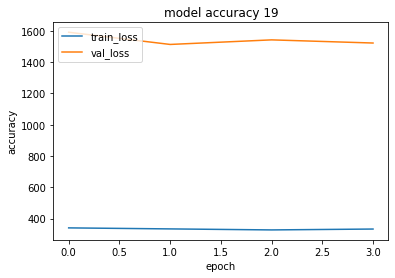

model_f19Saved model to disk


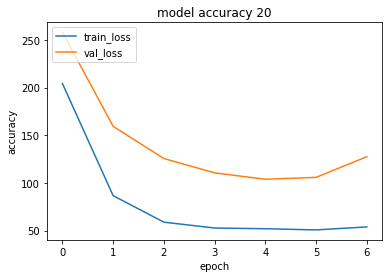

model_f20Saved model to disk


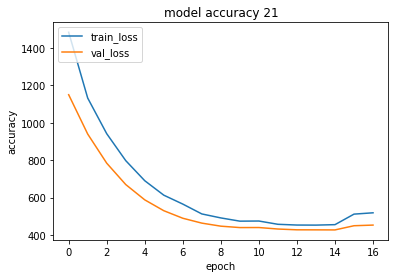

model_f21Saved model to disk


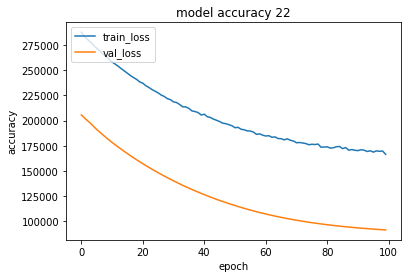

model_f22Saved model to disk


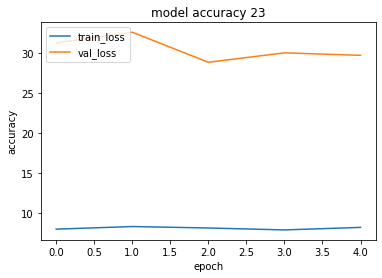

model_f23Saved model to disk


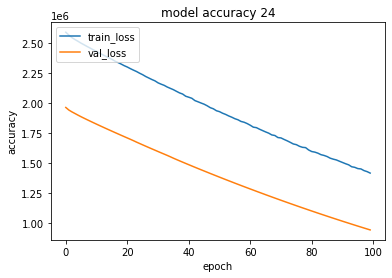

model_f24Saved model to disk


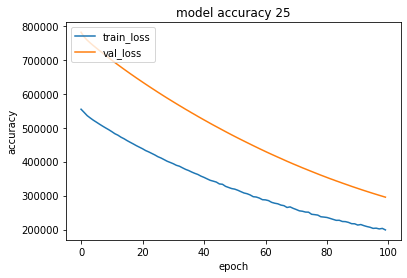

model_f25Saved model to disk


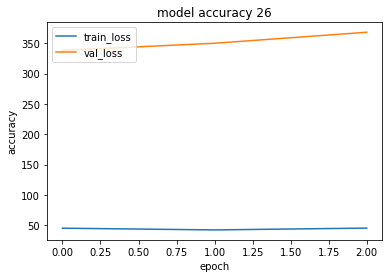

model_f26Saved model to disk


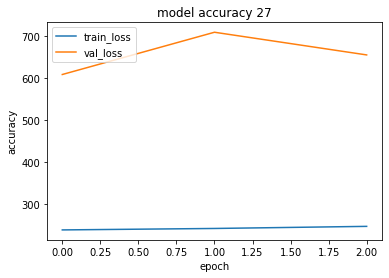

model_f27Saved model to disk


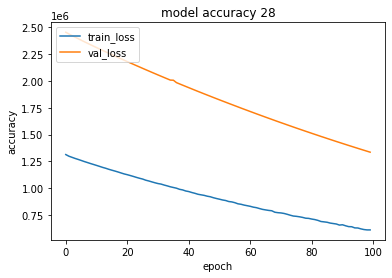

model_f28Saved model to disk


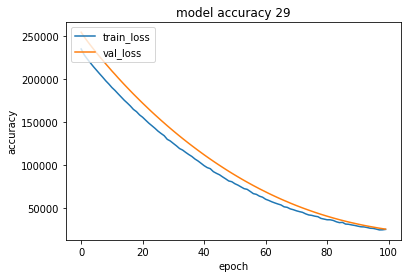

model_f29Saved model to disk


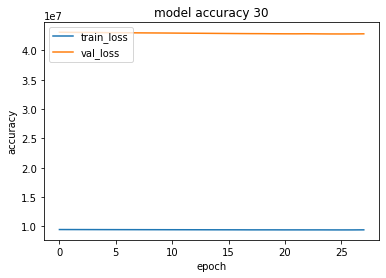

model_f30Saved model to disk


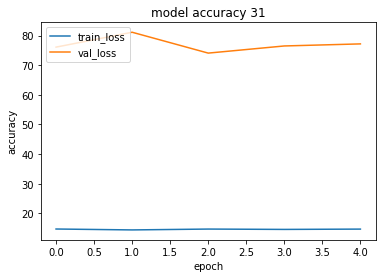

model_f31Saved model to disk


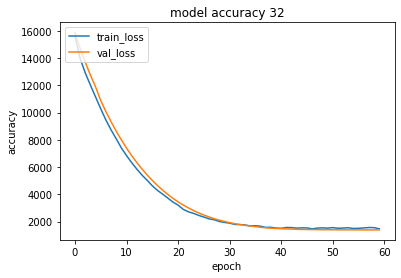

model_f32Saved model to disk


In [246]:
def draw(history,num):
    # val_acc = np.mean(history.history['val_accuracy'])
    # print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy '+str(num))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # plt.legend(['train_acc', 'validation_acc','train_loss','val_loss'], loc='upper left')
    plt.legend(['train_loss','val_loss'], loc='upper left')

    # plt.legend(['train','loss'], loc='upper left')
    plt.show()
for i in range(len(train_f_map)):
    model = train_f_map[i][2]
    history = train_f_map[i][3]

    draw(history,i)
    # serialize model to JSON
    model_json = model.to_json()
    with open(filepath+"model_f"+str(i)+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filepath+"model_f"+str(i)+".json.h5")
    print("model_f"+str(i)+"Saved model to disk")
    # break

# Perdict

In [247]:
test_x_all =  df[num_train:].copy().drop(columns=['sales'])
test_x_all = list(test_x_all.groupby(["family"],as_index=False))

train_x_all_buf =  df[:num_train].copy().drop(columns=['sales'])
train_x_all_buf = list(train_x_all_buf.groupby(["family"],as_index=False))

In [248]:
test_f_map=list()
for i in range(len(test_x_all)):
    test_x = test_x_all[i][1]
    test_x = test_x.groupby(['date'],as_index=False).agg(condition)

    family_num,train_x_buf = train_x_all_buf[i][0],train_x_all_buf[i][1]
    train_x_buf = train_x_buf.groupby(['date'],as_index=False).agg(condition)#ok
    # for col in number_cols+object_cols:
    #     if col=='sales':continue
    #     train_x_buf[col] = scaler.fit_transform(train_x_buf[col].values.reshape(-1,1))

    test_x = pd.concat([train_x_buf[-1*(history_input)+1:],test_x],ignore_index=True)
    test_f_map.append([test_x])


In [254]:
test_output = []
test_ = df[num_train:].copy()
for i in range(len(test_['date'])):
    test_input = []
    f_num = int(test_['family'].iloc[0])
    # print(f_num)
    test_x = test_f_map[f_num][0]

    end = test_x.index[test_x['date']==test_['date'].iloc[i]].tolist()[0]
    start = end - history_input + 1
    test_input.append(pd.concat([test_x[start:end],test_[i:i+1]]).drop(columns=['date','sales','family']).values)
    test_input=np.array(test_input)

    model = train_f_map[f_num][2]
    y_pred = model.predict(test_input)
    test_output.append(y_pred[0].tolist()[0])

    if i%100==0:
        print("Count ",i/100," *100 data.")


Count  0.0  *100 data.
Count  1.0  *100 data.
Count  2.0  *100 data.
Count  3.0  *100 data.
Count  4.0  *100 data.
Count  5.0  *100 data.
Count  6.0  *100 data.
Count  7.0  *100 data.
Count  8.0  *100 data.
Count  9.0  *100 data.
Count  10.0  *100 data.
Count  11.0  *100 data.
Count  12.0  *100 data.
Count  13.0  *100 data.
Count  14.0  *100 data.
Count  15.0  *100 data.
Count  16.0  *100 data.
Count  17.0  *100 data.
Count  18.0  *100 data.
Count  19.0  *100 data.
Count  20.0  *100 data.
Count  21.0  *100 data.
Count  22.0  *100 data.
Count  23.0  *100 data.
Count  24.0  *100 data.
Count  25.0  *100 data.
Count  26.0  *100 data.
Count  27.0  *100 data.
Count  28.0  *100 data.
Count  29.0  *100 data.
Count  30.0  *100 data.
Count  31.0  *100 data.
Count  32.0  *100 data.
Count  33.0  *100 data.
Count  34.0  *100 data.
Count  35.0  *100 data.
Count  36.0  *100 data.
Count  37.0  *100 data.
Count  38.0  *100 data.
Count  39.0  *100 data.
Count  40.0  *100 data.
Count  41.0  *100 data.
Co

In [255]:
print(test_output)

[24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287902832, 24.97087287

In [256]:
test_data = pd.read_csv('test.csv')
submit = test_data[['id']]
submit['sales'] = test_output

C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
submit.to_csv(filepath+"submit.csv",index=False,sep=',')
import zipfile
with zipfile.ZipFile(filepath+'submit.zip', 'w') as zf:
    zf.write(filepath+'submit.csv')